In [75]:
#pip install ultralytics supervision cvzone opencv-python-headless deep-sort-realtime easyocr

#### **Modelo de Computer Vision**: Traffic Flow

En este notebook, se desarrollará un modelo de AI para el conteo de vehículos utilizando las **cámaras** de las Estaciones de Servicio OPESSA.

In [76]:
import cv2
import supervision as sv
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort
import matplotlib.pyplot as plt

#### Carga de datos

Se carga el modelo YOLO y un metraje de video con una cantidad sabida de autos pasando en el video.

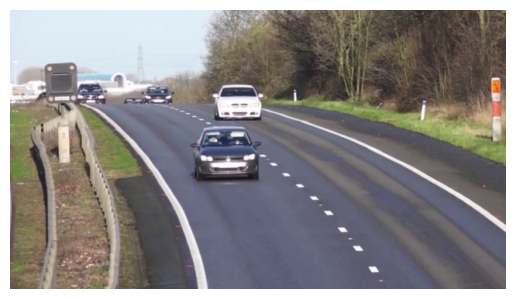

In [77]:
# Cargar el modelo YOLOv8
model = YOLO("yolov8n.pt")  # Utilizamos el modelo YOLOv8n lite para no tener problemas de performance.

# Parámetros del video de entrada y salida
input_video_path = r"C:\Users\se43484\YPF\GR - BI VPC - Equipo BI VPC - Equipo BI VPC\07 - Computer Vision\Traffic Flow\Modelo de Python CV\cinco autos pasando.mp4"
output_video_path = r"C:\Users\se43484\YPF\GR - BI VPC - Equipo BI VPC - Equipo BI VPC\07 - Computer Vision\Traffic Flow\Modelo de Python CV\cinco autos pasando conteo.mp4"

# Leer el primer frame del video
cap = cv2.VideoCapture(input_video_path)
ret, frame = cap.read()
cap.release()
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

#### __Contador de vehículos__

Para evitar que con YOLO contabilicemos el mismo vehículo en cada frame, utilizaremos un tracker con DeepSort, una librería que es muy efectiva para no duplicar conteos y trackear por id a los vehículos.

In [78]:
# Inicialización del contador de autos
car_count = 0
counted_ids = set()  # IDs de vehículos ya contados

# Inicializar DeepSORT
tracker = DeepSort(max_age=30, nn_budget=100, max_iou_distance=0.5, embedder="mobilenet", embedder_gpu=True)

#### __Configuración del video__

Con el objetivo de que todo los videos que sirvan de imput para el modelo estén estandarizados, y para mejorar la velocidad en el procesamiento, achicamos la resolución del video y reducimos en gran cantidad los fotogramas del mismo.

In [79]:
# Configuración del video
cap = cv2.VideoCapture(input_video_path)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

line_color = sv.Color.ROBOFLOW
bounding_box_color = sv.Color.GREEN

# Reducir los FPS para acelerar el procesamiento
skip_frames = max(fps // 7, 1)  # Procesar 10 frames por segundo o menos

# Reducir la resolución para acelerar el procesamiento
new_width = 640
new_height = int((new_width / width) * height)

# Configuración del video de salida
out = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), fps // skip_frames, (new_width, new_height))

#### Definición de __linea para conteo__ y anotaciones

El método aplicado será aplicar un contador que aumenta cada vez que un vehículo cruce una linea trazada a 1/3 de la base del video.

In [80]:
# Línea de conteo (color RoboFlow)
LINE_Y = int(new_height * 0.7)
LINE_START, LINE_END = (0, LINE_Y), (new_width, LINE_Y)

# Crear anotador de cajas delimitadoras (recuadros verdes)
box_annotator = sv.BoxAnnotator(color=sv.Color.GREEN, thickness=1)

#### Modelo de Computer Vision:

A continuación, se realiza el código que será el encargado de detectar los vehículos y contarlos.

In [81]:
#Con el objetivo de mostrar en el notebook resultados, se guardan algunos frames del video anotado final:

# Número de frames anteriores que deseas capturar
n_frames_back = 20  # Cambia este valor según tus necesidades

# Procesar el video frame por frame haciendo un loop
frame_index = 0
captured_frames = []  # Lista para almacenar los últimos n frames anotados

In [82]:
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:  # Si no se lee correctamente, sale del bucle.
        break

    # Saltar frames para reducir FPS
    if frame_index % skip_frames != 0:  # Si el frame no es múltiplo de skip_frames, salta al siguiente frame.
        frame_index += 1
        continue  # Salta al siguiente ciclo del bucle

    # Redimensionar el frame
    frame = cv2.resize(frame, (new_width, new_height))

    # Realizar la detección con YOLOv8
    results = model(frame)[0]
    detections = sv.Detections.from_ultralytics(results)  # Convierte al formato de detecciones

    # Filtrar autos (clase 2 en COCO)
    car_mask = detections.class_id == 2  # En el dataset de entrenamiento de YOLOv8, la clase 2 es la clase de los autos.
    car_detections = detections[car_mask]

    # Preparar detecciones para DeepSORT
    deepsort_detections = [[bbox.tolist(), float(conf)] for bbox, conf in zip(car_detections.xyxy, car_detections.confidence)]
    tracks = tracker.update_tracks(deepsort_detections, frame=frame)

    # Dibujar la línea de conteo (más fina y color RoboFlow)
    cv2.line(frame, LINE_START, LINE_END, line_color.as_bgr(), 2)

    # Procesar rastros para contar autos
    for track in tracks:
        if not track.is_confirmed():
            continue
        track_id = track.track_id
        x1, y1, w, h = track.to_ltwh()

        # Para que pruebas visuales sean más atractivas, reduzco el tamaño de los bounding boxes
        scaling_factor = 0.15  
        w = w * scaling_factor
        h = h * scaling_factor
        x1 = x1 + (1 - scaling_factor) * w / 2  # Centrar el nuevo bounding box
        y1 = y1 + (1 - scaling_factor) * h / 2

        bbox_center = (int(x1 + w / 2), int(y1 + h))

        # Comprobar si el auto cruza la línea y no ha sido contado aún
        if track_id not in counted_ids and bbox_center[1] > LINE_Y:
            car_count += 1
            counted_ids.add(track_id)
            cv2.circle(frame, bbox_center, 5, (0, 0, 255), -1)

        # Dibujar bounding box con el tamaño ajustado en verde (más fino)
        cv2.rectangle(frame, (int(x1), int(y1)), (int(x1 + w), int(y1 + h)), (0, 255, 0), 1)  # Grosor más fino

    # Mostrar el contador de autos en la parte superior del video en verde
    cv2.putText(frame, f"Cantidad de autos: {car_count}", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # Guardar el frame anotado en el video de salida
    out.write(frame)
    
    # Capturar los últimos n frames anotados
    captured_frames.append(frame.copy())
    if len(captured_frames) > n_frames_back:
        captured_frames.pop(0)
    
    frame_index += 1

# Liberar recursos
cap.release()
out.release()

# Imprimir el total de autos detectados
print(f"Total de autos detectados: {car_count}")


0: 384x640 5 cars, 2 trucks, 133.7ms
Speed: 12.8ms preprocess, 133.7ms inference, 6.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 1 truck, 108.4ms
Speed: 0.0ms preprocess, 108.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 1 truck, 120.1ms
Speed: 10.5ms preprocess, 120.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 1 truck, 164.3ms
Speed: 2.0ms preprocess, 164.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 1 bus, 1 truck, 119.0ms
Speed: 0.0ms preprocess, 119.0ms inference, 3.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 1 bus, 126.7ms
Speed: 9.5ms preprocess, 126.7ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 1 bus, 111.0ms
Speed: 0.0ms preprocess, 111.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 1 bus, 132.8ms
Speed: 0.0ms p

#### Resultado de la detección en el video:

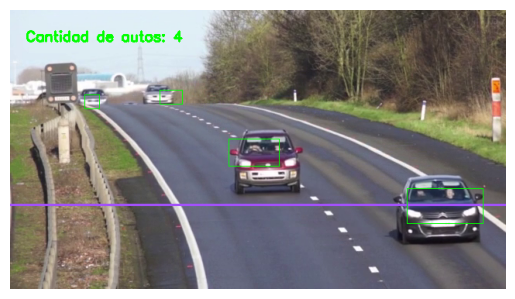

In [83]:
# Mostramos por pantalla uno de los frames intermedios del video analizado
if len(captured_frames) >= n_frames_back:
    frame_to_show = captured_frames[0]  # Cambia el índice según el frame que desees mostrar
    plt.imshow(cv2.cvtColor(frame_to_show, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
else:
    print("No se pudo capturar el frame deseado.")

#### Lector de precios de la competencia

Utilizando OCR, la idea del proyecto es apuntar la cámara a EESS de la competencia y obtener en tiempo real el precio al que comercializan su combustible.

In [ ]:
import cv2
import easyocr

# Inicializar el lector de EasyOCR
reader = easyocr.Reader(['es'])

# Leer la imagen
image_path = r"C:\Users\se43484\YPF\GR - BI VPC - General\07 - Computer Vision\Traffic Flow\Modelo de Python CV\OIP (3).jpg"
image = cv2.imread(image_path)

# Verificar si la imagen se ha cargado correctamente
if image is None:
    print("Error al cargar la imagen.")
else:
    # Realizar OCR en la imagen
    results = reader.readtext(image)

    # Imprimir los resultados de OCR
    for (bbox, text, prob) in results:
        print(f"Texto: {text}, Probabilidad: {prob}")